### Scan for optimal npatch and n_bootstrap values

Number of galaxies after cuts: 21857
Number of random points: 2185700


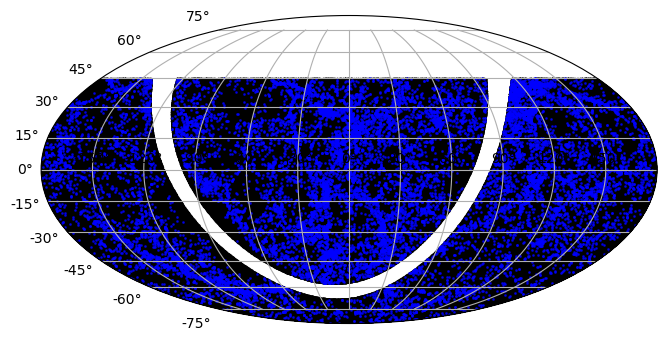


Computing for npatch = 100...
patch gal counts min/med/mean = 85/198.0/218.6

Computing for npatch = 200...
patch gal counts min/med/mean = 37/94.5/109.3

Computing for npatch = 300...
patch gal counts min/med/mean = 16/65.0/72.9

Computing for npatch = 400...
patch gal counts min/med/mean = 11/50.0/54.6

Computing for npatch = 500...
patch gal counts min/med/mean = 3/39.0/43.7

Computing for npatch = 600...
patch gal counts min/med/mean = 6/32.0/36.4
Using optimal_npatch = 100

Computing for n_bootstrap = 100...
The following patch numbers have no objects: {2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79, 80, 81, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97}
This may be a problem depending on your use case.

Computing for n_bootstrap = 200...


KeyboardInterrupt: 

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import treecorr

# --------------------------- User parameters ---------------------------
GLADE_FILE = "../../data/GLADE_zhelio_lt0.1_dL_lt300.txt"
FLUX_FILE = "../../data/Auger/flux_a8_lb.dat"

N_RAND_PER_GAL = 100
MIN_CZ = 1200
MAX_CZ = 6000
MK_CUT = -20.0
MAX_DEC = 45.0
THETA_CUTOFF = 20.0  # degrees for your metric

TC_CONFIG = {
    "min_sep": 1,
    "max_sep": 65.,
    "nbins": 13,
    "sep_units": 'degree',
    "bin_type": 'Linear',
    "brute": False,
    "metric": 'Arc',
    "var_method": 'bootstrap',
    "cross_patch_weight": 'geom'
}

# --------------------------- Helper functions ---------------------------

def read_GLADE(cols_to_use, cz_min=MIN_CZ, dL_max=200, filename=GLADE_FILE):
    from get_masks import get_milkyway_mask

    c = 299792.458
    chunksize = 200_000

    with open(filename, 'r') as f:
        header = f.readline().lstrip('#').split()

    filtered_chunks = []

    for chunk in pd.read_csv(
            filename,
            sep=r'\s+',  # future-proof replacement for delim_whitespace
            names=header,
            usecols=cols_to_use,
            skiprows=1,
            chunksize=chunksize):

        chunk = chunk[chunk["dist_flag"] != 0]
        chunk["cz"] = c * chunk["z_cmb"]
        chunk = chunk[(chunk["cz"] > cz_min) & (chunk["d_L"] < dL_max)]
        chunk["M_K"] = chunk["K"] - 5 * np.log10(chunk["d_L"]) - 25
        mask = (
            np.isfinite(chunk["M_K"]) &
            np.isfinite(chunk["d_L"]) &
            np.isfinite(chunk["RA"]) &
            np.isfinite(chunk["Dec"])
        )
        filtered_chunks.append(chunk.loc[mask])

    df = pd.concat(filtered_chunks, ignore_index=True)
    df["M_K"] = df["K"] - 5 * np.log10(df["d_L"]) - 25

    # apply Milky Way mask and dec cut
    df = df.iloc[get_milkyway_mask(df["RA"].values, df["Dec"].values)]
    df = df[df['Dec'] < MAX_DEC]

    return df


def generate_RanCat(N_total, dec_min=-90, dec_max=MAX_DEC, seed=None):
    from get_masks import get_milkyway_mask
    rng = np.random.default_rng(seed)
    factor = 4
    rand_ra = rng.uniform(0, 360, N_total * factor)
    rand_sindec = rng.uniform(np.sin(np.radians(dec_min)), np.sin(np.radians(dec_max)), N_total * factor)
    rand_dec = np.degrees(np.arcsin(rand_sindec))

    mask = get_milkyway_mask(rand_ra, rand_dec)
    rand_ra = rand_ra[mask][:N_total]
    rand_dec = rand_dec[mask][:N_total]
    if len(rand_ra) < N_total:
        raise ValueError("Not enough random points generated after masking")
    return rand_ra, rand_dec


def compute_corr(gal_ra, gal_dec,
                 rand_ra_fixed, rand_dec_fixed,
                 flux_ra, flux_dec, flux_val, npatch):
    """
    Returns: meanr, xi, varxi, empty_flag
    empty_flag=True if TreeCorr emitted an empty-patch warning (or we found empty patches)
    """
    # Build galaxy catalog with patches
    gcat = treecorr.Catalog(ra=gal_ra, dec=gal_dec, ra_units='deg', dec_units='deg', npatch=npatch)

    # Build random catalog using same patch centers
    rand_cat = treecorr.Catalog(ra=rand_ra_fixed, dec=rand_dec_fixed,
                                ra_units='deg', dec_units='deg',
                                patch_centers=gcat.patch_centers)

    fcat = treecorr.Catalog(ra=flux_ra, dec=flux_dec, k=flux_val,
                            ra_units='deg', dec_units='deg')

    nk = treecorr.NKCorrelation(TC_CONFIG)
    rk = treecorr.NKCorrelation(TC_CONFIG)

    nk.process(gcat, fcat)
    rk.process(rand_cat, fcat)

    # Now compute NK/RK and scaled variance using TreeCorr's calculateXi
    rk_xi = rk.xi.copy()
    xi, varxi = nk.calculateXi(rk=rk)
    # normalize
    # As discussed, in your case using rk.xi is safe; keep it for ordinary TreeCorr usage
    tiny = 1e-30
    rk_xi[np.abs(rk_xi) < tiny] = tiny
    xi = xi / rk_xi
    varxi = varxi / (rk_xi ** 2)

    return nk.meanr, xi, varxi

def converged(vals, tol=0.05, window=3):
    """
    Returns True if the last `window` values differ from the previous value
    by less than `tol` (relative difference).
    Example: if window=3, compares vals[-4] to vals[-3:], vals[-2], vals[-1].
    """
    if len(vals) < window + 1:
        return False

    recent = np.array(vals[-window:])
    ref = vals[-window-1]

    # handle small denominator
    if abs(ref) < 1e-12:
        return np.all(np.abs(recent - ref) < 1e-12)

    rel_change = np.abs((recent - ref) / ref)
    return np.all(rel_change <= tol)

# --------------------------- Main script ---------------------------


npatch_list = [100, 200, 300, 400, 500, 600]
n_bootstrap_list = [100, 200, 500, 1000, 2000]


# --------------------------- Load DATA ---------------------------
# load galaxies
cols = ["RA", "Dec", "z_cmb", "d_L", "dist_flag", "K"]
gxs = read_GLADE(cols, cz_min=MIN_CZ, filename=GLADE_FILE)
gxs = gxs[gxs['cz'] < MAX_CZ]
print(f"Number of galaxies after cuts: {len(gxs)}")

# Generate random catalog (seed for reproducibility)
N_rand = len(gxs) * N_RAND_PER_GAL
rand_ra_fixed, rand_dec_fixed = generate_RanCat(N_rand, seed=12345)
print(f"Number of random points: {len(rand_ra_fixed)}")

# skyplot 
plt.figure(figsize=(8,4))
plt.subplot(111, projection="mollweide")
rand_ra_rad = np.radians(-rand_ra_fixed + 180.0)  # shift for mollweide
rand_dec_rad = np.radians(rand_dec_fixed)
plt.scatter(rand_ra_rad, rand_dec_rad, s=.1, color='k', alpha=0.5)
plt.scatter(np.radians(-gxs['RA'].values + 180.0), np.radians(gxs['Dec'].values), \
            s=1, color='blue', alpha=0.7)
plt.grid(True)
plt.show()

# Load flux catalog
flux_cat = np.loadtxt(FLUX_FILE)
flux_dec = flux_cat[:, 0]
flux_ra = flux_cat[:, 1]
flux_val = flux_cat[:, 2]


# --------------------------- NPATCH TEST ---------------------------
variance_list = []

for npatch in npatch_list:
    print(f"\nComputing for npatch = {npatch}...")


    # Build galaxy catalog with patches
    gcat = treecorr.Catalog(ra=gxs['RA'], dec=gxs['Dec'], ra_units='deg', dec_units='deg', npatch=npatch)

    # patch stats
    gpatch = gcat.patch
    gcounts = np.bincount(gpatch, minlength=npatch)
    #print(gcounts)
    print(f"patch gal counts min/med/mean = {gcounts.min()}/{np.median(gcounts):.1f}/{gcounts.mean():.1f}")
    if gcounts.min() < 10:
        n_gcounts_lt10 = len(np.where(gcounts < 10)[0])
        print(f"WARNING: {n_gcounts_lt10} patches have very few galaxies (<10). Bootstrap may be unstable.")
        
        # If 10% or more patches have <10 galaxies, stop the scan
        if n_gcounts_lt10 / npatch >= 0.1:
            print("Too many low-count patches; stopping npatch scan here.")
            break

    # quick manual empty-patch check (fast)
    if np.any(gcounts == 0):
        print(f"  ❌ Empty patches detected ({np.sum(gcounts == 0)} patches). Stopping here.")
        break

    optimal_npatch = npatch

if 'optimal_npatch' not in locals():
    raise RuntimeError("Did not find optimal_npatch. Terminating.")
    exit()

# --------------------------- N_BOOTSTRAP TEST ---------------------------
variance_list_bootstrap = []

# require optimal_npatch to be set
try:
    chosen_npatch = optimal_npatch
except NameError:
    raise RuntimeError("optimal_npatch not found. Choose a valid npatch from the npatch scan results.")

# JUST FOR TESTING
chosen_npatch = 100

print('Using optimal_npatch =', chosen_npatch)

for n_bootstrap in n_bootstrap_list:
    print(f"\nComputing for n_bootstrap = {n_bootstrap}...")

    TC_CONFIG["n_bootstrap"] = n_bootstrap

    meanr, xi, varxi = compute_corr(
        gxs['RA'].values, gxs['Dec'].values,
        rand_ra_fixed, rand_dec_fixed,
        flux_ra, flux_dec, flux_val,
        chosen_npatch
    )

    # Compute stability metric for θ ≤ THETA_CUTOFF
    mask_ang = (meanr <= THETA_CUTOFF)
    xi_t = xi[mask_ang]
    var_t = varxi[mask_ang]

    score_b = np.sqrt(np.sum(var_t)) / (np.sum(np.abs(xi_t)) + 1e-12)
    variance_list_bootstrap.append(score_b)

    # Analyze variance stability
    if converged(variance_list_bootstrap, tol=0.05, window=3):
        optimal_n_bootstrap = n_bootstrap
        print(f"Converged: optimal n_bootstrap = {optimal_n_bootstrap}")
        break


# Plot bootstrap stability
plt.figure(figsize=(8,6))
plt.plot(n_bootstrap_list[:len(variance_list_bootstrap)], variance_list_bootstrap, marker='o')
plt.grid(True)
plt.xlabel("Number of Bootstraps (n_bootstrap)")
plt.ylabel("Stability metric (sqrt(var)/sum|xi|, θ≤20°)")
plt.title("Bootstrap Variance Stability Test")
plt.show()
